In [1]:
import numpy as np
import matplotlib.pyplot as plt

################################################################################################################################################################
#The model has 1 input layer with 1 node, 1 hidden layer with 100 nodes and 1 output layer with 1 node. Sigmoid function is used
#as the activation function for the hidden layer. Backpropagation algorithm is implemented and all gradient calculations are
#attached in the submission. Each method has a description above itself and its mathematical formula is in also attached image
#with corresponding numbers.
################################################################################################################################################################

#Image eq.no: 1
#Sample error values for w with N(0, 1)
def sample_error(size):
    return np.random.randn(*size)

#Image eq. no: 2
#Apply the formula of std given in the paper
def calculate_std(rho):
    return np.log(1 + np.exp(rho))

#Image eq. no: 3
#Apply the formula of w given mu, rho and errors
def calculate_w(mu, rho, error):
    std = calculate_std(rho)
    w = mu + np.multiply(std, error)
    return w

#Image eq. no: 4
#Take the derivative of w with respect to mu
def grad_w_wrt_mu(mu, rho, error):
    return 1

#Image eq. no: 5
#Take the derivative of w with respect to rho
def grad_w_wrt_rho(mu, rho, error):
    return np.multiply(np.divide(np.exp(rho), (1 + np.exp(rho))), error)

#Image eq. no: 6
#Sigmoid function as the hidden layer activation function
def sigmoid(x):
    return 1 / (1 + np.exp(- x))

#Image eq. no: 7
#Gradient of sigmoid with respect to its parameter
def grad_sigmoid(k):
    return sigmoid(k) * (1 - sigmoid(k))

#Image eq. no: 8
#Log of normal distribution pdf formula
def log_prob_of_normal_dist(x, mu, std):
    return (- np.log(np.sqrt(2 * np.pi)) - np.log(std) - np.divide(np.multiply((x - mu), (x - mu)), (2 * np.multiply(std, std))))

#Image eq. no: 9
#For loss function of the model Kullback-Leibler divergence is used. In addition MSE is also calculated and reported.
#Loss function of the model: f(w, theta)
def calculate_loss(w0, w0_mu, w0_rho, w1, w1_mu, w1_rho, prior_std, tol, data):
    #Variational posterior probabilities and prior probabilities are calculated for each layer and then summed up. 
    log_var_post_prob0 = np.zeros(shape = w0.shape)
    log_prior_prob0 = np.zeros(shape = w0.shape)
    var_post_std0 = calculate_std(w0_rho)
    for r in range(w0.shape[0]):
        for c in range(w0.shape[1]):
            log_var_post_prob0[r][c] = log_prob_of_normal_dist(w0[r][c], w0_mu[r][c], var_post_std0[r][c])
            log_prior_prob0[r][c] = log_prob_of_normal_dist(w0[r][c], 0, prior_std)
    log_var_post_prob1 = np.zeros(shape = w1.shape)
    log_prior_prob1 = np.zeros(shape = w1.shape)
    var_post_std1 = calculate_std(w1_rho)
    for r in range(w1.shape[0]):
        for c in range(w1.shape[1]):
            log_var_post_prob1[r][c] = log_prob_of_normal_dist(w1[r][c], w1_mu[r][c], var_post_std1[r][c])
            log_prior_prob1[r][c] = log_prob_of_normal_dist(w1[r][c], 0, prior_std)
    #Likelihood is calculated for the sample.
    x = data[0]
    y = data[1]
    log_likelihood = np.zeros(shape = x.shape)
    y_pred = predict(w0, w1, x)
    for i in range(y_pred.shape[0]):
        log_likelihood[i] = log_prob_of_normal_dist(y[i], y_pred[i][0], tol)
    #Variational posteriors and priors are for each layer and summed up. At the end, total summation is divided to the sample
    #size in order to eliminate the sample size effect on the loss.
    loss = (np.sum((log_var_post_prob0 + np.transpose(log_var_post_prob1)) - (log_prior_prob0 + np.transpose(log_prior_prob1))) - np.sum(log_likelihood)) / x.shape[0]
    mse = (np.square(y - y_pred)).mean(axis = 0)[0]
    return loss, mse

#Image eq. no: 10
#Take the derivative of log-likelihood with respect to y_pred
def grad_log_likelihood_wrt_y_pred(w0, w1, x, y, tol):
    y_pred = predict(w0, w1, x)
    return np.divide((y - y_pred), (tol ** 2))

#Image eq. no: 11
#Take the derivative of y_pred with respect to w1
def grad_y_pred_wrt_w1(w0, x):
    return sigmoid(np.matmul(x, np.transpose(w0)))

#Image eq. no: 12
#Take derivative of KL loss with respect to mu1
def grad_loss_wrt_mu1(mu0, rho0, errors0, mu1, rho1, errors1, data, tol):
    x = data[0]
    y = data[1]
    w0 = calculate_w(mu0, rho0, errors0)
    w1 = calculate_w(mu1, rho1, errors1)
    delta_log_var_post = 0
    delta_log_prior = - calculate_w(mu1, rho1, errors1)
    delta_log_likelihood = np.multiply(np.matmul(np.transpose(grad_log_likelihood_wrt_y_pred(w0, w1, x, y, tol)), grad_y_pred_wrt_w1(w0, x)), grad_w_wrt_mu(mu1, rho1, errors1))
    return delta_log_var_post - delta_log_prior - delta_log_likelihood

#Image eq. no: 13
#Take derivative of KL loss with respect to mu0
def grad_loss_wrt_mu0(mu0, rho0, errors0, mu1, rho1, errors1, data, tol):
    x = data[0]
    y = data[1]
    w0 = calculate_w(mu0, rho0, errors0)
    w1 = calculate_w(mu1, rho1, errors1)
    delta_log_var_post = 0
    delta_log_prior = - calculate_w(mu0, rho0, errors0)
    delta_log_likelihood = np.matmul(np.transpose(np.multiply(np.matmul(grad_log_likelihood_wrt_y_pred(w0, w1, x, y, tol), w1), grad_sigmoid(np.matmul(x, np.transpose(w0))))), x)
    return delta_log_var_post - delta_log_prior - delta_log_likelihood

#Image eq. no: 14
#Take derivative of KL loss with respect to rho1
def grad_loss_wrt_rho1(mu0, rho0, errors0, mu1, rho1, errors1, data, tol):
    x = data[0]
    y = data[1]
    w0 = calculate_w(mu0, rho0, errors0)
    w1 = calculate_w(mu1, rho1, errors1)
    delta_log_var_post = - np.multiply(np.multiply(np.divide(1, np.log(1 + np.exp(rho1))), np.divide(1, (1 + np.exp(rho1)))), np.exp(rho1))
    delta_log_prior = - np.multiply(calculate_w(mu1, rho1, errors1), grad_w_wrt_rho(mu1, rho1, errors1))
    delta_log_likelihood = np.multiply(np.matmul(np.transpose(grad_log_likelihood_wrt_y_pred(w0, w1, x, y, tol)), grad_y_pred_wrt_w1(w0, x)), grad_w_wrt_rho(mu1, rho1, errors1))
    return delta_log_var_post - delta_log_prior - delta_log_likelihood

#Image eq. no: 15
#Take derivative of KL loss with respect to rho1
def grad_loss_wrt_rho0(mu0, rho0, errors0, mu1, rho1, errors1, data, tol):
    x = data[0]
    y = data[1]
    w0 = calculate_w(mu0, rho0, errors0)
    w1 = calculate_w(mu1, rho1, errors1)
    delta_log_var_post = - np.multiply(np.multiply(np.divide(1, np.log(1 + np.exp(rho0))), np.divide(1, (1 + np.exp(rho0)))), np.exp(rho0))
    delta_log_prior = - np.multiply(calculate_w(mu0, rho0, errors0), grad_w_wrt_rho(mu0, rho0, errors0))
    delta_log_likelihood = np.multiply(np.matmul(np.transpose(np.multiply(np.matmul(grad_log_likelihood_wrt_y_pred(w0, w1, x, y, tol), w1), grad_sigmoid(np.matmul(x, np.transpose(w0))))), x), grad_w_wrt_rho(mu0, rho0, errors0))
    return delta_log_var_post - delta_log_prior - delta_log_likelihood

#Image eq. no: 16
#Update the mu and rho parameters of each layer
#np.clip is used to overcome exploding gradients
def update(w0, w0_mu, w0_rho, w1, w1_mu, w1_rho, prior_std, tol, data, errors0, errors1, lr):
    w0_mu = w0_mu - lr * np.clip(grad_loss_wrt_mu0(w0_mu, w0_rho, errors0, w1_mu, w1_rho, errors1, data, tol), -1, 1)
    w0_rho = w0_rho - lr * np.clip(grad_loss_wrt_rho0(w0_mu, w0_rho, errors0, w1_mu, w1_rho, errors1, data, tol), -1, 1)
    w1_mu = w1_mu - lr * np.clip(grad_loss_wrt_mu1(w0_mu, w0_rho, errors0, w1_mu, w1_rho, errors1, data, tol), -1, 1)
    w1_rho = w1_rho - lr * np.clip(grad_loss_wrt_rho1(w0_mu, w0_rho, errors0, w1_mu, w1_rho, errors1, data, tol), -1, 1)
    return w0_mu, w0_rho, w1_mu, w1_rho

#Train the model
#At the beginning of training, errors are sampled for w0 and w1. After that, at each epoch w0 and w1 are calculated according
#to new w1_mu, w1_rho, w0_mu and w0_rho parameters and forward passed to calculate the KL loss and MSE. Backward pass is also
#applied to take derivatives, update the model parameters which are w1_mu, w1_rho, w0_mu and w0_rho. 
def train(w0_mu, w0_rho, w1_mu, w1_rho, prior_std, tol, data, lr, epochs = 1000):
    f_list = list()
    mse_list = list()
    w0_errors = sample_error(w0_mu.shape)
    w1_errors = sample_error(w1_mu.shape)
    for e in range(epochs):
        w0 = calculate_w(w0_mu, w0_rho, w0_errors)
        w1 = calculate_w(w1_mu, w1_rho, w1_errors)
        #Forward pass
        f, mse = calculate_loss(w0, w0_mu, w0_rho, w1, w1_mu, w1_rho, prior_std, tol, data)
        f_list.append(f)
        mse_list.append(mse)
        #Backward pass
        w0_mu, w0_rho, w1_mu, w1_rho = update(w0, w0_mu, w0_rho, w1, w1_mu, w1_rho, prior_std, tol, data, w0_errors, w1_errors, lr)
        if e % 50 == 0:
            print('Epoch', e, '=> F:', f, ', MSE:', mse)
    return w0_mu, w0_rho, w1_mu, w1_rho, f_list, mse_list

#Image eq. no: 17
#Predict method of the model
def predict(w0, w1, x):
    return np.matmul(sigmoid(np.matmul(x, np.transpose(w0))), np.transpose(w1))

#Image eq. no: 18
#Non-linear regression curve equation to train and test the model
def curve(x, errors):
    y = 10 * np.sin(2 * np.pi * (x)) + errors
    return y

#Train data generation method
#Sample regression curve errors with N(0, e_std) where default e_std is 1.0 and apply curve function to generate y truth
def reg_curve(x, e_std = 1.0):
    errors = np.random.randn(*x.shape) * e_std
    y = curve(x, errors)
    return y

#A function to plot the generated train data
def plot_train_data(train_data):
    x = train_data[0]
    y = train_data[1]
    plt.figure(figsize = (8, 8))
    plt.scatter(x, y, marker = 'x')
    plt.title('Train Data')
    plt.show()

#A function to plot the model results with the train data, mean of model predictions and interquantile ranges with 2*std and 3*std
def plot_result(train_data, x_test, y_preds_mean, y_preds_sigma):
    x_train = train_data[0]
    y_train = train_data[1]
    plt.figure(figsize = (8, 8))
    plt.plot(x_test, y_preds_mean, c = 'r', label = 'y_predicted_mean')
    plt.scatter(x_train, y_train, c = 'black', marker = 'x', label = 'train_data')
    plt.fill_between(x_test.ravel(), y_preds_mean + 3 * y_preds_sigma, y_preds_mean - 3 * y_preds_sigma,
                     alpha = 0.5, label = 'interquantile range with 3*sigma')
    plt.fill_between(x_test.ravel(), y_preds_mean + 2 * y_preds_sigma, y_preds_mean - 2 * y_preds_sigma,
                     alpha = 0.5, label = 'interquantile range with 2*sigma')
    plt.title('Results')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend(loc = 'best')
    plt.show()

#A function to plot the loss vs epoch graph
def plot_train_loss(loss_list, title):
    plt.figure(figsize = (8, 8))
    plt.plot(loss_list)
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()

In [2]:
################################################################################################################################################################
#Setting the model parameters
################################################################################################################################################################

#Train sample size
train_size = 1000

#Generate x values for train sample
x_train = np.linspace(-0.5, 0.5, train_size).reshape(-1, 1)

#Genrate y values for train sample with reg_curve function
y_train = reg_curve(x_train, e_std = 1.0)

#Train data tuple with x and y values
train_data = (x_train, y_train)

#Data x feature size
input_dim = x_train.shape[1]

#Data y feature size
output_dim = y_train.shape[1]

#Hidden layer total nodes
hidden_size = 100

#It is assumed that the prior distributions of w0 and w1 are N(0, 1)
prior_std = 1.0

#Uniform randomly initialize w0_mu and w0_rho parameters of w0
w0_mu = np.random.uniform(low = -0.2, high = 0.2, size = (hidden_size, input_dim))
w0_rho = np.random.uniform(low = -5, high = -4, size = (hidden_size, input_dim))

#Uniform randomly initialize w1_mu and w1_rho parameters of w1
w1_mu = np.random.uniform(low = -0.2, high = 0.2, size = (output_dim, hidden_size))
w1_rho = np.random.uniform(low = -5, high = -4, size = (output_dim, hidden_size))

#Tolerance parameter is used as std for log-likelihood distribution which is also N(y_pred, tol)
tol = 0.2

#Learning rate of the model
lr = 0.01

#Training total epochs
epochs = 2000

Epoch 0 => F: 647.7537920385505 , MSE: 51.810628032740524
Epoch 50 => F: 468.29390324262056 , MSE: 37.4528314158589
Epoch 100 => F: 258.9655183820822 , MSE: 20.702897250939476
Epoch 150 => F: 257.51489935775317 , MSE: 20.58951948654672
Epoch 200 => F: 253.86403189604098 , MSE: 20.298787429695345
Epoch 250 => F: 247.99644187487772 , MSE: 19.82937219090868
Epoch 300 => F: 239.86723664459097 , MSE: 19.178190118564377
Epoch 350 => F: 228.65286646705772 , MSE: 18.279215571670584
Epoch 400 => F: 214.52447448119688 , MSE: 17.14570337977201
Epoch 450 => F: 197.99375174831806 , MSE: 15.818712556892221
Epoch 500 => F: 173.65881681149193 , MSE: 13.865545568527441
Epoch 550 => F: 142.16677974456593 , MSE: 11.336583413306919
Epoch 600 => F: 109.71842795579389 , MSE: 8.728088778431742
Epoch 650 => F: 83.23262049505874 , MSE: 6.594889710035794
Epoch 700 => F: 64.1716540949892 , MSE: 5.0545209353330485
Epoch 750 => F: 52.28062850859339 , MSE: 4.087059964176668
Epoch 800 => F: 44.25846073101207 , MSE: 

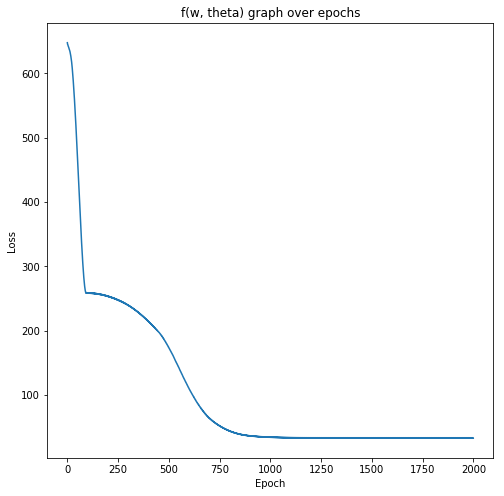

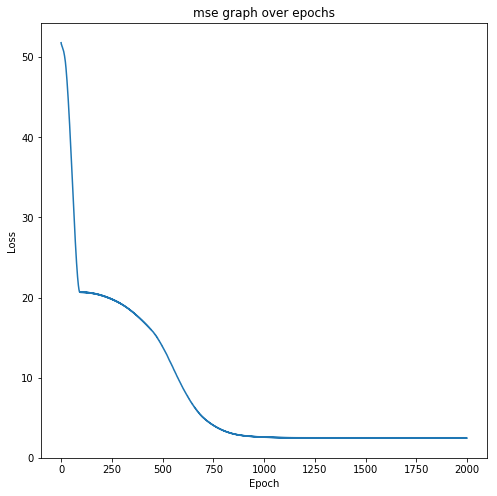

In [3]:
################################################################################################################################################################
#Train the model and plot KL loss vs epoch and MSE vs epoch graphs to report the model performance on the train sample
################################################################################################################################################################

#Train the model and keep records of KL divergence loss and MSE
w0_mu, w0_rho, w1_mu, w1_rho, loss_list, mse_list = train(w0_mu, w0_rho, w1_mu, w1_rho, prior_std, tol, train_data, lr, epochs = epochs)

#Plot KL loss vs epoch graph
plot_train_loss(loss_list, title = 'f(w, theta) graph over epochs')

#Plot MSE vs epoch graph
plot_train_loss(mse_list, title = 'mse graph over epochs')

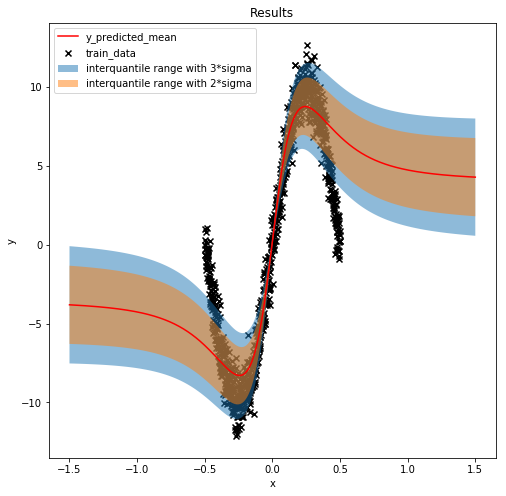

In [4]:
################################################################################################################################################################
#Test the model and plot the model result graph to report the model performance on the test sample
################################################################################################################################################################

#Generate x values for the test sample
x_test = np.linspace(-1.5, 1.5, 1000).reshape(-1, input_dim)

#Create a list to record model predictions
y_pred_list = []

#Trained model parameters are w1_mu, w1_rho, w0_mu and w0_rho. Model is tested on average, so 1000 model with learned w1_mu,
#w1_rho, w0_mu and w0_rho parameters and random w0 and w1 errors are predicted the y values with the same x values of the test
#sample. Each model prediction is recorded, and then the mean and standard deviation are calculated for each x value of the test
#sample.
for i in range(1000):
    w0_errors = sample_error(w0_mu.shape)
    w1_errors = sample_error(w1_mu.shape)
    w0 = calculate_w(w0_mu, w0_rho, w0_errors)
    w1 = calculate_w(w1_mu, w1_rho, w1_errors)
    y_pred = predict(w0, w1, x_test)
    y_pred_list.append(y_pred)
#Calculate the mean and standard deviation of predicted y values for each x value of the test sample
y_preds = np.concatenate(y_pred_list, axis = 1)
y_preds_mean = np.mean(y_preds, axis = 1)
y_preds_sigma = np.std(y_preds, axis = 1)

#Plot the model results to evaluate the model performance on the test sample which has several data points from where the model
#was not trained
plot_result(train_data, x_test, y_preds_mean, y_preds_sigma)